# Simplex Method

In [5]:
import numpy as np

In [205]:
class SimplexMethod:
    @staticmethod
    def __find_col(simplex_table, *, debug=False):
        column = np.argmin(simplex_table[-1, 1:])
        column += 1
        if debug:
            print(f'column: {column}')
        return column

    @staticmethod
    def __iter(simplex_table, base, *, eps=1e-9, debug=False):
        simplex_table_old = np.copy(simplex_table)
        column = SimplexMethod.__find_col(simplex_table, debug=debug)

        with np.errstate(divide='ignore'):
            d = simplex_table[:-1, 0] / simplex_table[: -1, column]
        d[simplex_table[:-1, column] <= 0] = np.NAN

        try:
            row = np.nanargmin(d)
        except ValueError:
            raise RuntimeError('None or infinity solutions')

        base[row] = column

        if debug:
            with np.printoptions(precision=3, suppress=True):
                print(f'd: {d}')
                print(f'column: {column}, row: {row}, a_rl: {simplex_table[row, column]}')
                print(simplex_table)

        simplex_table[row, :] /= simplex_table_old[row, column]
        simplex_table[:, column] = 0
        simplex_table[row, column] = 1

        for i in range(simplex_table.shape[0]):
            for j in range(simplex_table.shape[1]):
                if i == row or j == column:
                    continue
                simplex_table[i, j] = simplex_table_old[i, j] - (simplex_table_old[row, j] * simplex_table_old[i, column]) / simplex_table_old[row, column]

        simplex_table[abs(simplex_table) < eps] = 0
        return simplex_table, base

    @staticmethod
    def create_plan(game):
        limits = game
        simplex_table = np.hstack((np.ones((limits.shape[0], 1)), limits, np.eye(limits.shape[0])))
        simplex_table = np.vstack((simplex_table, np.hstack((np.array([0]), np.ones(limits.shape[1]) * -1, np.zeros(limits.shape[0])))))
        return simplex_table

    @staticmethod
    def solve_reverse(simplex_table, base, *, debug=False):
        res_table, res_base = SimplexMethod.solve(simplex_table, base, debug=debug)

        table = simplex_table[: -1, res_base]
        D = np.linalg.inv(table)
        C = np.zeros(res_table.shape[1] - 1)
        C[res_base - 1] = 1
        C = C[ : -res_table.shape[0] + 1]
        return np.dot(C, D)



    @staticmethod
    def solve(simplex_table, base, *, debug=False):
        table = np.copy(simplex_table)
        while np.any(table[-1, 1:] < 0):
            table, base = SimplexMethod.__iter(table, base, debug=debug)
        return table, base

    @staticmethod
    def solve_game(game, *, debug=False):
        plan = SimplexMethod.create_plan(game)
        base = np.arange(plan.shape[1] - plan.shape[0] + 1, plan.shape[1])
        table, base = SimplexMethod.solve(plan, base, debug=debug)
        a1 = SimplexMethod.solve_game_A(table, base, debug=debug)
        a2 = SimplexMethod.solve_game_B(plan, base, debug=debug)
        v = 1 / table[-1, 0]
        return v, v * a1,  v * a2

    @staticmethod
    def solve_game_A(simplex_table, base, *, debug=False):
        C = np.zeros(simplex_table.shape[1] - 1)
        C[base - 1] = simplex_table[:-1, 0] 
        C = C[ : -simplex_table.shape[0] + 1] 
        return C

    @staticmethod
    def solve_game_B(simplex_table, base, *, debug=False):
        table = simplex_table[: -1, base]
        D = np.linalg.inv(table)
        C = np.zeros(simplex_table.shape[1] - 1)
        C[base - 1] = 1
        C = C[ : -simplex_table.shape[0] + 1]
        return np.dot(C, D)


# Tasks

## Task 1

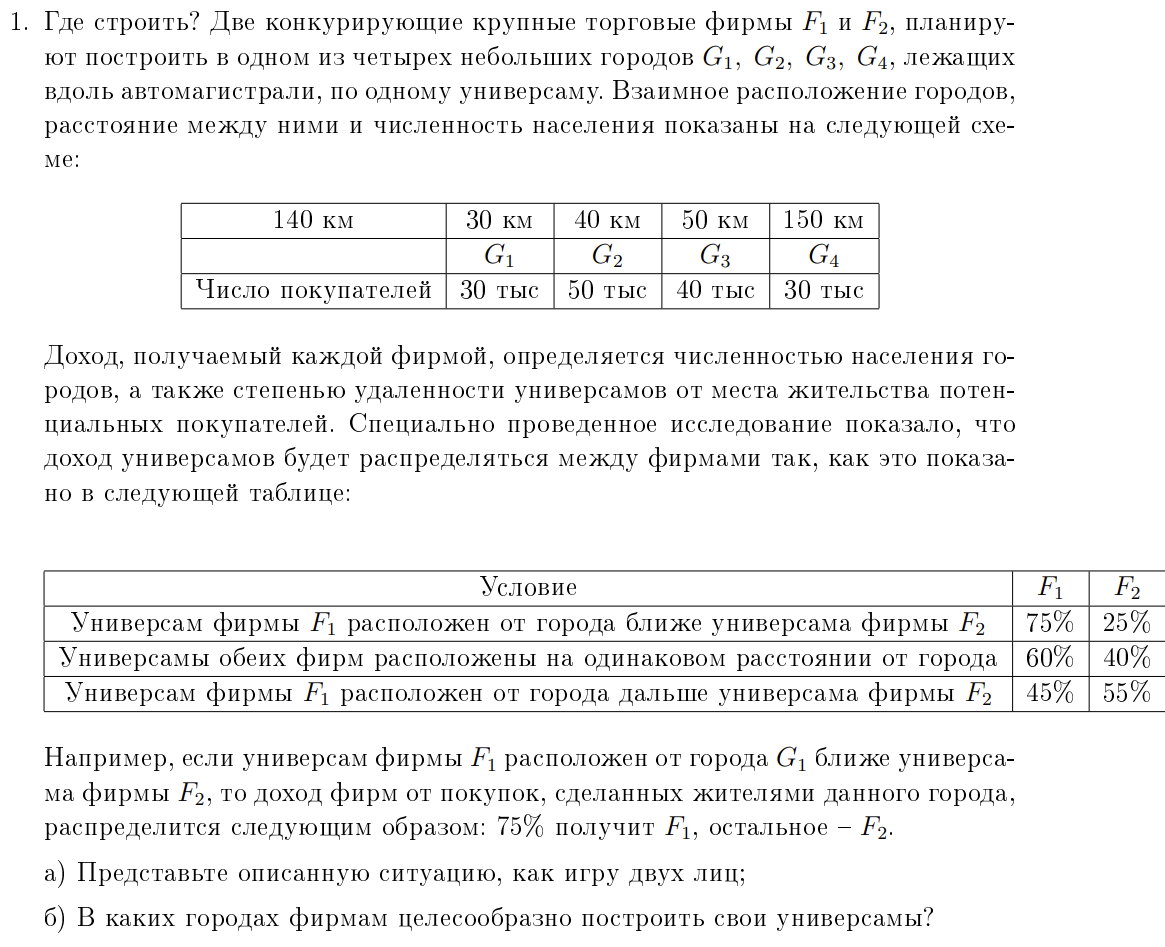

In [166]:
dist_matrix = [
    [30, 40, 50, 150],
    [30, 50, 40, 30]
]

def get_profit(f1, f2, g):
    f1_dst = sum(dist_matrix[0][f1:g]) if f1 < g else sum(dist_matrix[0][g:f1])
    f2_dst = sum(dist_matrix[0][g:f2]) if g < f2 else sum(dist_matrix[0][f2:g])
    if f1_dst > f2_dst:
        return dist_matrix[1][g] * 0.45
    elif f1_dst < f2_dst:
        return dist_matrix[1][g] * 0.75
    else:
        return dist_matrix[1][g] * 0.60

def generate_matrix():
    matrix = np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            profit = sum([get_profit(i, j, g) for g in range(4)])
            matrix[i][j] = profit
    return matrix


In [193]:
matrix = generate_matrix()
matrix

array([[ 90. ,  76.5,  91.5,  91.5],
       [103.5,  90. ,  91.5, 103.5],
       [ 88.5,  88.5,  90. , 103.5],
       [ 88.5,  76.5,  76.5,  90. ]])

In [206]:
v, p1, p2 = SimplexMethod.solve_game(matrix, debug=False)
print(f'v: {v}')
print(f'p1: {p1}')
print(f'p2: {p2}')

v: 90.0
p1: [0. 1. 0. 0.]
p2: [0. 1. 0. 0.]


## Task 2

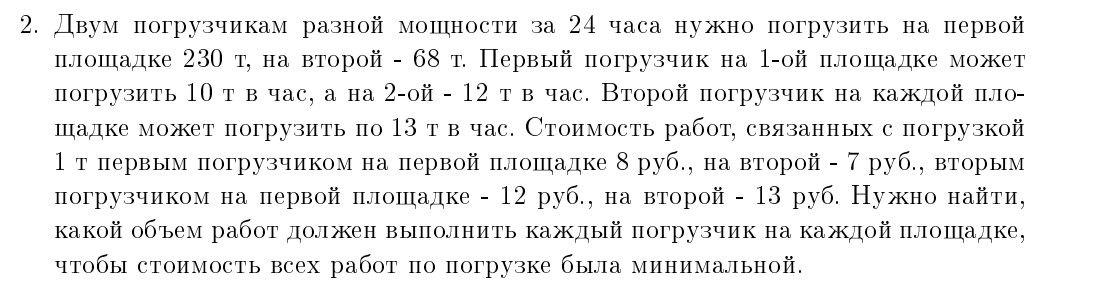

Пусть $x_1$ - колличество работы, которую выполнил 1 погрузчик на 1 площадке, а $x_2$ - на второй 

Пусть $x_3$ - колличество работы, которую выполнил 2 погрузчик на 1 площадке, а $x_4$ - на второй

Тогда $F(x) = 8x_1 + 7x_2 + 12x_3 + 13x_4 \rightarrow \min$

Ограничения:
\begin{equation}
    \begin{cases}
    x_1 + x_3 = 230\\
    x_2 + x_4 = 68\\
    \frac{x_1}{10} + \frac{x_2}{12} \leq 24\\
    \frac{x_3}{13} + \frac{x_4}{13} \leq 24\\
    \frac{x_1}{10} + \frac{x_3}{13} \leq 24\\
    \frac{x_2}{12} + \frac{x_4}{13} \leq 24\\
    \end{cases}
\end{equation}


Воспользуемся лабораторной №1(мне слишком лень переносить сюда еще и метод дополнительного базиса)

8x1+7x2+12x3+13x4

x1+x3=230

X2+x4=68

0.1x1+0.083x2<=24

0.077x3+0.077x4<=24

0.1x1+0.076x3<=24

0.083x2+0.076x4<=24

4

In [7]:
res = np.array([2.50266667e+03, 1.83333333e+02, 6.80000000e+01, 4.66666667e+01,
       0.00000000e+00])
res

array([2502.66667  ,  183.333333 ,   68.       ,   46.6666667,
          0.       ])

Cледовательно: первый должен выкопать на 1-ом участке 183т, а на втором - 68т, второй же должен работать только на 1-ом участке и выкопать всего 47т. стоить же это будет 2504р